## Keras LSTM Time-Series Prediction

Long Short-Term Memory (LSTM) Recurrent Neural Network (RNN) can be used to learn time-series data. Using Mean Square Error as a loss function it is possible to the future values of a time series. Here, an LSTM RNN is trained on the closing price of S&P500 time series with a lookback window of 10 days. A trading strategy can be constructed by using LSTM prediction price change sign as a signal for upward or downward price movement. For a momentum strategy, we long S&P500 whenever prediction is above a positive threshold, we short S&P500 when the prediction is below a negative threshold and we clear positions otherwise. 


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from pandas_datareader import data
from datetime import datetime
import pytz

import matplotlib.pyplot as plt

np.random.seed(0)

Using Theano backend.


In [2]:
def create_dataset(dataset, look_back=1):

    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        dataX.append(dataset[i:(i+look_back),0])
        dataY.append(dataset[i+look_back,0])

    return np.array(dataX), np.array(dataY)

In [3]:
#load data
start = datetime(2015, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime(2016, 1, 1, 0, 0, 0, 0, pytz.utc)
spy = data.DataReader("SPY", "google", start, end)
dataset = np.array(spy['Close'].values).reshape(-1,1)
dataset = dataset.astype('float32')
spy.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,206.38,206.88,204.18,205.43,121465865
2015-01-05,204.17,204.37,201.35,201.72,169632646
2015-01-06,202.09,202.72,198.86,199.82,209151408
2015-01-07,201.42,202.72,200.88,202.31,125346709
2015-01-08,204.01,206.16,203.99,205.90,147217784


We scale the closing price to 0 to 1 range:

In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

In [6]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [8]:
# reshape for look_back
look_back = 10
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# reshape for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

Next, we define our model:

In [9]:
# LSTM
model = Sequential()
model.add(LSTM(32, input_dim=1)) #look_back))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, nb_epoch=100, batch_size=5, verbose=2)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(32, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/keras/models.py:850: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use

Epoch 1/100
0s - loss: 0.3131
Epoch 2/100
0s - loss: 0.0229
Epoch 3/100
0s - loss: 0.0158
Epoch 4/100
0s - loss: 0.0158
Epoch 5/100
0s - loss: 0.0151
Epoch 6/100
0s - loss: 0.0153
Epoch 7/100
0s - loss: 0.0155
Epoch 8/100
0s - loss: 0.0149
Epoch 9/100
0s - loss: 0.0144
Epoch 10/100
0s - loss: 0.0142
Epoch 11/100
0s - loss: 0.0144
Epoch 12/100
0s - loss: 0.0140
Epoch 13/100
0s - loss: 0.0140
Epoch 14/100
0s - loss: 0.0136
Epoch 15/100
0s - loss: 0.0133
Epoch 16/100
0s - loss: 0.0133
Epoch 17/100
0s - loss: 0.0129
Epoch 18/100
0s - loss: 0.0126
Epoch 19/100
0s - loss: 0.0126
Epoch 20/100
0s - loss: 0.0124
Epoch 21/100
0s - loss: 0.0124
Epoch 22/100
0s - loss: 0.0141
Epoch 23/100
0s - loss: 0.0127
Epoch 24/100
0s - loss: 0.0139
Epoch 25/100
0s - loss: 0.0119
Epoch 26/100
0s - loss: 0.0115
Epoch 27/100
0s - loss: 0.0113
Epoch 28/100
0s - loss: 0.0110
Epoch 29/100
0s - loss: 0.0111
Epoch 30/100
0s - loss: 0.0110
Epoch 31/100
0s - loss: 0.0112
Epoch 32/100
0s - loss: 0.0108
Epoch 33/100
0s -

In [10]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

In [11]:
# scale back 
train_pred = scaler.inverse_transform(train_pred)
y_train = scaler.inverse_transform(y_train)
test_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform(y_test) 

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [12]:
# shift predictions for plotting
train_pred_plot = np.empty_like(dataset)
train_pred_plot[:,:] = np.nan
train_pred_plot[look_back:len(train_pred)+look_back,:] = train_pred

test_pred_plot = np.empty_like(dataset)
test_pred_plot[:,:] = np.nan
test_pred_plot[len(train_pred)+(look_back*2)+1:len(dataset)-1,:] = test_pred

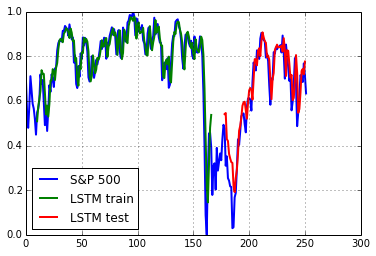

In [13]:
plt.figure()
plt.plot(scaler.inverse_transform(dataset), color='b', lw=2.0, label='S&P 500')
plt.plot(train_pred_plot, color='g', lw=2.0, label='LSTM train')
plt.plot(test_pred_plot, color='r', lw=2.0, label='LSTM test')
plt.legend(loc=3)
plt.grid(True)

The figure above shows LSTM predictions on the training (green) and the test (red) time series. We can see the regression results closely match the actual market price.